Import Sentiment related modules

In [16]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get the current working directory
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

# Check if we need to change directory to the project root
if os.path.basename(current_dir) == 'scripts':
    project_root = os.path.dirname(current_dir)
    os.chdir(project_root)
    print(f"Changed working directory to: {project_root}")
    sys.path.append(current_dir)
else:
    scripts_path = os.path.join(current_dir, 'scripts')
    if os.path.exists(scripts_path):
        sys.path.append(scripts_path)

# Import modules
try:
    from sentiment_utils import apply_bert_sentiment, aggregate_sentiment
except ImportError as e:
    # Fallback logic if imports fail directly
    sys.path.append(os.getcwd())
    from sentiment_utils import apply_bert_sentiment, aggregate_sentiment


Current working directory: c:\Users\mihret.mekbebe\Documents\REQUESTS\KAIM\Customer-Experience-Analytics-for-Fintech-Apps-Week2


In [17]:
# Load the processed data
data_path = os.path.join(project_root, 'data', 'processed', 'reviews_processed.csv')
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Data file not found: {data_path}")
reviews_df = pd.read_csv(data_path)
# Apply BERT sentiment analysis
reviews_df = apply_bert_sentiment(reviews_df, "review_text")
# Aggregate sentiment scores
sentiment_df = aggregate_sentiment(reviews_df, "bank_code", "rating", "bert_score")  


In [18]:
reviews_df.head()  # Display the first few rows of the DataFrame

,review_text,rating,review_date,bank_code,bank_name,source,bert_sentiment,bert_score,bert_numeric
0,🙏👍,5,2025-11-29,BOA,Bank of Abyssinia,Google Play,NEGATIVE,0.697057,-1
1,Very Good,5,2025-11-28,BOA,Bank of Abyssinia,Google Play,POSITIVE,0.999852,1
2,goof,5,2025-11-28,BOA,Bank of Abyssinia,Google Play,NEGATIVE,0.997528,-1
3,good!,5,2025-11-28,BOA,Bank of Abyssinia,Google Play,POSITIVE,0.999827,1
4,good jop,5,2025-11-27,BOA,Bank of Abyssinia,Google Play,POSITIVE,0.999841,1


In [19]:
sentiment_df.head()  # Display the first few rows of the aggregated sentiment DataFrame

,bank_code,rating,bert_score
0,BOA,1,0.975930
1,BOA,2,0.952529
2,BOA,3,0.961126
3,BOA,4,0.944500
4,BOA,5,0.950363


Box plots to compare each banks Sentiment Scores

C:\Users\mihret.mekbebe\AppData\Local\Temp\ipykernel_18724\3085357395.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=banks)


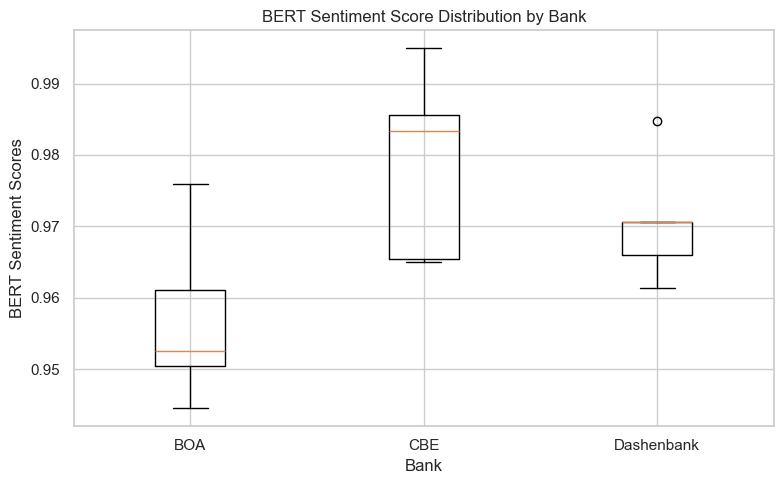

In [20]:
plt.figure(figsize=(8, 5))
banks = sentiment_df['bank_code'].unique() # Get unique bank codes

data = [sentiment_df[sentiment_df['bank_code'] == b]['bert_score'] for b in banks] # Prepare data for boxplot
plt.boxplot(data, labels=banks) 
plt.xlabel('Bank')
plt.ylabel('BERT Sentiment Scores')
plt.title('BERT Sentiment Score Distribution by Bank')
plt.tight_layout()
plt.show()

Heatmap to show relationship between ratings and bert_score for each banks

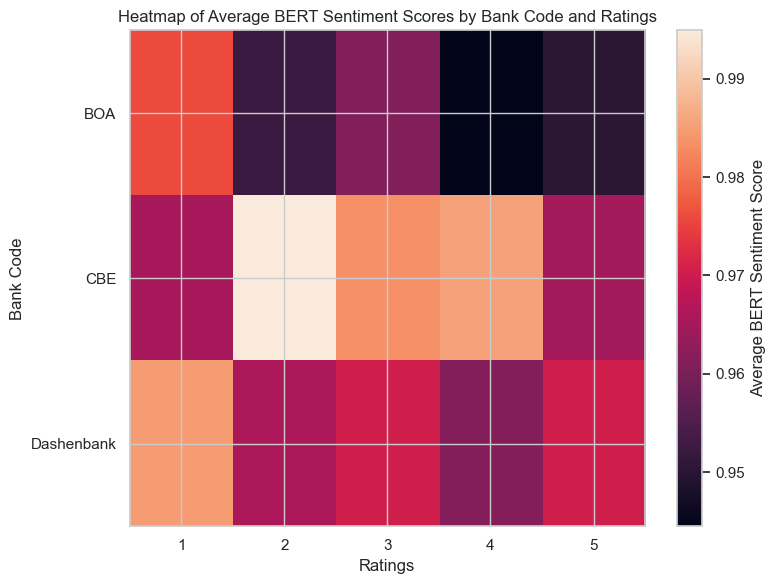

In [21]:
pivot = sentiment_df.pivot(index='bank_code', columns='rating', values='bert_score') # Create pivot table for heatmap
plt.figure(figsize=(8, 6))
plt.imshow(pivot, aspect='auto')
plt.xticks(ticks=range(len(pivot.columns)), labels=pivot.columns) # Set x-ticks to ratings
plt.yticks(ticks=range(len(pivot.index)), labels=pivot.index) # Set y-ticks to bank codes
plt.colorbar(label='Average BERT Sentiment Score')
plt.xlabel('Ratings')
plt.ylabel('Bank Code')
plt.title('Heatmap of Average BERT Sentiment Scores by Bank Code and Ratings')
plt.tight_layout()
plt.show()

Import Thematic related modules

In [22]:
import numpy as np
import spacy
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix


Word Frequency Calculation

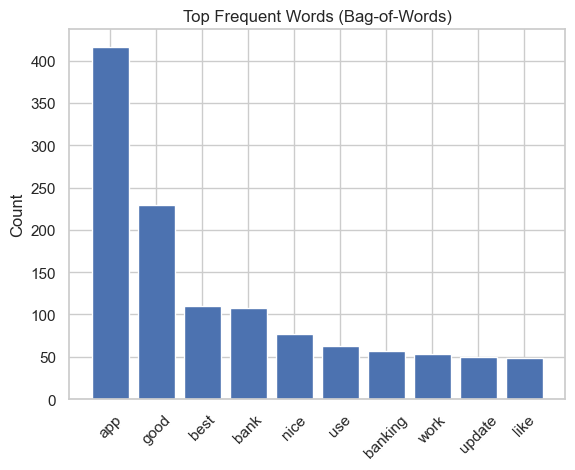

In [23]:
# Frequency-based word counts using CountVectorizer
reviews_df['clean_text'] = reviews_df['review_text'].str.lower()  # Lowercase the text

count_vec = CountVectorizer(stop_words="english")
X_counts = count_vec.fit_transform(reviews_df["clean_text"])

# Sum counts for each word across all documents
word_counts = np.asarray(X_counts.sum(axis=0)).flatten()
vocab = np.array(count_vec.get_feature_names_out())

freq_df = pd.DataFrame({"word": vocab, "count": word_counts})
freq_df = freq_df.sort_values("count", ascending=False)

# Plot top frequent words (Frequency-Based)

top_n = 10
top_freq = freq_df.head(top_n)

plt.bar(top_freq["word"], top_freq["count"])
plt.xticks(rotation=45)
plt.title("Top Frequent Words (Bag-of-Words)")
plt.ylabel("Count")
plt.show()


TF-IDF representation

In [24]:
tfidf_vec = TfidfVectorizer(stop_words="english") # TF-IDF Vectorizer
X_tfidf = tfidf_vec.fit_transform(reviews_df["clean_text"]) # TF-IDF matrix

# Get average TF-IDF score per word across documents
tfidf_means = np.asarray(X_tfidf.mean(axis=0)).flatten()
vocab_tfidf = np.array(tfidf_vec.get_feature_names_out())

tfidf_df = pd.DataFrame({"word": vocab_tfidf, "tfidf": tfidf_means})
tfidf_df = tfidf_df.sort_values("tfidf", ascending=False)
tfidf_df.head()


,word,tfidf
673,good,0.134926
126,app,0.082036
214,best,0.062452
995,nice,0.046506
186,bank,0.021118


Tokenization

In [25]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

# Tokenize text (very simple split for demo)
reviews_df["tokens"] = reviews_df["clean_text"].str.split()

# Create dictionary and corpus for LDA
dictionary = Dictionary(reviews_df["tokens"])
corpus = [dictionary.doc2bow(tokens) for tokens in reviews_df["tokens"]]


In [26]:
import nltk
from nltk.corpus import stopwords

# Download stopwords (only first time)
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))
# Remove stopwords from your tokenized text
reviews_df["tokens_nostop"] = reviews_df["tokens"].apply(
    lambda words: [w for w in words if w not in stop_words]
)

reviews_df[["clean_text", "tokens", "tokens_nostop"]].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mihret.mekbebe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,clean_text,tokens,tokens_nostop
0,🙏👍,[🙏👍],[🙏👍]
1,very good,"[very, good]",[good]
2,goof,[goof],[goof]
3,good!,[good!],[good!]
4,good jop,"[good, jop]","[good, jop]"


Topic Modeling

In [27]:
# Use stopword-cleaned tokens
dictionary = Dictionary(reviews_df["tokens_nostop"]) # Create dictionary from tokens without stopwords
corpus = [dictionary.doc2bow(tokens) for tokens in reviews_df["tokens_nostop"]] # Create corpus from tokens without stopwords

# Build LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=2,
    passes=10,
    random_state=42
)


In [28]:
topics = lda_model.show_topics(num_topics=2, num_words=10, formatted=False)

for i, topic in topics:
    print(f"\n--- Topic {i+1} ---")
    for word, weight in topic:
        print(f"{word:15s}  weight={weight:.4f}")



--- Topic 1 ---
app              weight=0.0596
bank             weight=0.0149
nice             weight=0.0131
please           weight=0.0094
best             weight=0.0092
use              weight=0.0091
time             weight=0.0071
update           weight=0.0069
work             weight=0.0068
banking          weight=0.0064

--- Topic 2 ---
good             weight=0.0553
best             weight=0.0165
application      weight=0.0076
great            weight=0.0070
ነው               weight=0.0055
like             weight=0.0054
wow              weight=0.0050
banking          weight=0.0047
boa              weight=0.0045
app              weight=0.0039


In [29]:
import spacy

nlp = spacy.load("en_core_web_sm") 

def extract_nouns(text):
    doc = nlp(text)
    return [token.text for token in doc if token.pos_ == "NOUN"]

reviews_df["nouns"] = reviews_df["review_text"].apply(extract_nouns)
reviews_df.head()


,review_text,rating,review_date,bank_code,bank_name,source,bert_sentiment,bert_score,bert_numeric,clean_text,tokens,tokens_nostop,nouns
0,🙏👍,5,2025-11-29,BOA,Bank of Abyssinia,Google Play,NEGATIVE,0.697057,-1,🙏👍,[🙏👍],[🙏👍],[]
1,Very Good,5,2025-11-28,BOA,Bank of Abyssinia,Google Play,POSITIVE,0.999852,1,very good,"[very, good]",[good],[]
2,goof,5,2025-11-28,BOA,Bank of Abyssinia,Google Play,NEGATIVE,0.997528,-1,goof,[goof],[goof],[goof]
3,good!,5,2025-11-28,BOA,Bank of Abyssinia,Google Play,POSITIVE,0.999827,1,good!,[good!],[good!],[]
4,good jop,5,2025-11-27,BOA,Bank of Abyssinia,Google Play,POSITIVE,0.999841,1,good jop,"[good, jop]","[good, jop]",[jop]


Rule-Based Clustering

In [30]:
themes = {
    "Account Access Issues": ["login", "password", "access", "otp", "blocked", "user"],
    "Transaction Performance": ["transfer", "transaction", "delay", "payment", "processing", "time"],
    "App Reliability & Bugs": ["crash", "bug", "error", "freeze", "update", 'work'],
    "User Interface & Experience": ["ui", "design", "navigation", "screen", "layout" ,"bank", "app", "application"]
}

def assign_theme(token_list): # Assign themes based on presence of keywords
    assigned = []
    for theme, words in themes.items():
        if any(word in token_list for word in words):
            assigned.append(theme)
    return assigned

reviews_df['themes'] = reviews_df['tokens'].apply(assign_theme)
reviews_df.head(10)

,review_text,rating,review_date,bank_code,bank_name,source,bert_sentiment,bert_score,bert_numeric,clean_text,tokens,tokens_nostop,nouns,themes
0,🙏👍,5,2025-11-29,BOA,Bank of Abyssinia,Google Play,NEGATIVE,0.697057,-1,🙏👍,[🙏👍],[🙏👍],[],[]
1,Very Good,5,2025-11-28,BOA,Bank of Abyssinia,Google Play,POSITIVE,0.999852,1,very good,"[very, good]",[good],[],[]
2,goof,5,2025-11-28,BOA,Bank of Abyssinia,Google Play,NEGATIVE,0.997528,-1,goof,[goof],[goof],[goof],[]
3,good!,5,2025-11-28,BOA,Bank of Abyssinia,Google Play,POSITIVE,0.999827,1,good!,[good!],[good!],[],[]
4,good jop,5,2025-11-27,BOA,Bank of Abyssinia,Google Play,POSITIVE,0.999841,1,good jop,"[good, jop]","[good, jop]",[jop],[]
5,bad exprience...it is so crushed,1,2025-11-27,BOA,Bank of Abyssinia,Google Play,NEGATIVE,0.999805,-1,bad exprience...it is so crushed,"[bad, exprience...it, is, so, crushed]","[bad, exprience...it, crushed]",[exprience],[]
6,not user friendly at all it requires a huge co...,1,2025-11-26,BOA,Bank of Abyssinia,Google Play,NEGATIVE,0.999766,-1,not user friendly at all it requires a huge co...,"[not, user, friendly, at, all, it, requires, a...","[user, friendly, requires, huge, connectivity,...","[user, connectivity, times]",[Account Access Issues]
7,ምንም የማይ ሰራ,1,2025-11-26,BOA,Bank of Abyssinia,Google Play,NEGATIVE,0.833725,-1,ምንም የማይ ሰራ,"[ምንም, የማይ, ሰራ]","[ምንም, የማይ, ሰራ]",[],[]
8,very good,5,2025-11-25,BOA,Bank of Abyssinia,Google Play,POSITIVE,0.999852,1,very good,"[very, good]",[good],[],[]
9,most of the time is not working properly,1,2025-11-25,BOA,Bank of Abyssinia,Google Play,NEGATIVE,0.999764,-1,most of the time is not working properly,"[most, of, the, time, is, not, working, properly]","[time, working, properly]",[time],[Transaction Performance]


In [ ]:
from config import DATA_PATHS
reviews_df = reviews_df.reset_index().rename(columns={"index": "review_id"}) # Reset index and rename for review_id

reviews_df_spec = reviews_df[["review_id","review_text", "bert_sentiment", "bert_score", "themes"]]
reviews_df_spec.head()
reviews_df_spec.to_csv(DATA_PATHS['final_results'], index=False) # Save the final results
